In [1]:
import pandas as pd
import sklearn
import numpy as np
df = pd.read_csv('cleaned.csv')

In [2]:
df = df.loc[~df.year_built.isnull()]

In [3]:
##Leaving only price and predictors/groups.

df = df.drop(['details', 
              'special_features',  
              'transaction_type', 
              'listing_status', 
              'listing_special_features', 
              'census_state_name', 
              'census_county_name', 'Unnamed: 0', 'rent'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10313 entries, 0 to 10341
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   latitude              10313 non-null  float64
 1   longitude             10313 non-null  float64
 2   full_street_address   10313 non-null  object 
 3   city                  10313 non-null  object 
 4   county_name           10313 non-null  object 
 5   beds                  10313 non-null  float64
 6   baths_full            10313 non-null  float64
 7   baths_half            10313 non-null  float64
 8   square_footage        10313 non-null  float64
 9   lot_size              10313 non-null  float64
 10  year_built            10313 non-null  float64
 11  price                 10313 non-null  int64  
 12  zipcode               10313 non-null  int64  
 13  overall_crime_grade   10313 non-null  object 
 14  property_crime_grade  10313 non-null  object 
 15  HS_rating          

In [5]:
pd.set_option('display.max_rows', 100)
df.zipcode.value_counts()

30052    170
30135    109
30157    103
30132    100
30032     99
        ... 
31709      1
31815      1
30445      1
31901      1
31791      1
Name: zipcode, Length: 339, dtype: int64

In [6]:
## Below will be a template for other models. The intent is for model-agnosticism to inform design.

## We do not have sufficient data to actually justify running a model at every zip code.
## Nevertheless, we will code that up, as it will be simple to apply to a subset of zips.

## We should look into grouping smaller zip codes if relevant.

## Import necessary models/tools

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import shap
import pickle

In [7]:
## creates dataframe for each zipcode
zip_dfs=[]
for zipcode in sorted(set(df.zipcode.values)):
    zip_dfs.append((df.loc[df.zipcode==zipcode,:], zipcode)
                  )
    
    
    
## list for models
models = []

## list for shap values and explainers
shaps = []



for zdf in zip_dfs:
    
    X = zdf[0].drop(['price', 
                     'caprate',
                     'zipcode',
                     "latitude",
                     'longitude', 
                     'city', 
                     'full_street_address', 
                     'county_name', 
                     'overall_crime_grade', ## latter two need to be turned into ordinals...
                     'property_crime_grade'], axis=1)

    y = zdf[0][['caprate']]
    
    if len(zdf[0]) == 1:
        X_train = X
        y_train = y
        
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y,
            train_size = 0.8,
            random_state = 0)
    
    models.append((LinearRegression().fit(X_train, y_train), zdf[1]))
    
    explainer = shap.Explainer(models[-1][0], X)
    shap_values = explainer(X)
    shaps.append([explainer, shap_values])

In [8]:
zip_dfs

[(       latitude  longitude     full_street_address              city  \
  4756  33.763815 -84.260612    2971 Majestic Circle  Avondale Estates   
  4757  33.780163 -84.254295         408 Rammel Oaks  Avondale Estates   
  4758  33.758259 -84.265213      1264 Berkeley Road  Avondale Estates   
  4759  33.769978 -84.265717        52 Berkeley Road  Avondale Estates   
  4760  33.780861 -84.252075  185 Forest Glen Circle  Avondale Estates   
  
          county_name  beds  baths_full  baths_half  square_footage  lot_size  \
  4756  DeKalb-County   4.0         3.0         0.0          2471.0       0.0   
  4757  DeKalb-County   4.0         3.0         1.0          2844.0       0.0   
  4758  DeKalb-County   4.0         3.0         0.0          2702.0       0.0   
  4759  DeKalb-County   3.0         3.0         0.0          4005.0       0.0   
  4760  DeKalb-County   3.0         1.0         1.0          1092.0       0.0   
  
        year_built   price  zipcode overall_crime_grade property

In [9]:
# # Fits the explainer
# explainer = shap.Explainer(models[-1], X)
# # Calculates the SHAP values - It takes some time
# shap_values = explainer(X)

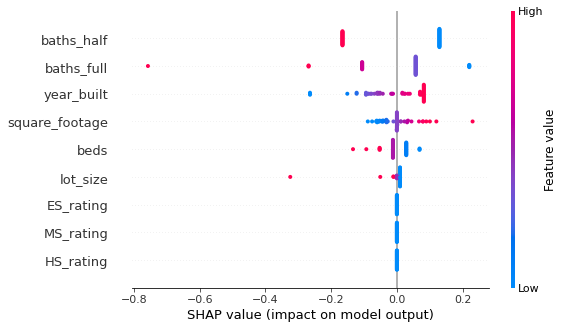

In [10]:
shap.plots.beeswarm(shaps[5][1])

In [20]:
shap.waterfall_plot(shaps[5][1].base_values[0], values[0])

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [11]:
filename = 'linear_models.sav'
pickle.dump(models, open(filename, 'wb'))

In [12]:
models

[(LinearRegression(), 30002),
 (LinearRegression(), 30004),
 (LinearRegression(), 30005),
 (LinearRegression(), 30008),
 (LinearRegression(), 30009),
 (LinearRegression(), 30012),
 (LinearRegression(), 30013),
 (LinearRegression(), 30014),
 (LinearRegression(), 30016),
 (LinearRegression(), 30017),
 (LinearRegression(), 30019),
 (LinearRegression(), 30022),
 (LinearRegression(), 30024),
 (LinearRegression(), 30025),
 (LinearRegression(), 30028),
 (LinearRegression(), 30030),
 (LinearRegression(), 30032),
 (LinearRegression(), 30033),
 (LinearRegression(), 30034),
 (LinearRegression(), 30038),
 (LinearRegression(), 30039),
 (LinearRegression(), 30040),
 (LinearRegression(), 30041),
 (LinearRegression(), 30043),
 (LinearRegression(), 30044),
 (LinearRegression(), 30045),
 (LinearRegression(), 30046),
 (LinearRegression(), 30047),
 (LinearRegression(), 30052),
 (LinearRegression(), 30054),
 (LinearRegression(), 30056),
 (LinearRegression(), 30058),
 (LinearRegression(), 30060),
 (LinearRe